# Learning process animation 

In this notebook I look at agents that return Rock, Paper or Scissors from multinomial distribution with learnable parameters. <br>
Only agents with single strategy (single distribution) are considered. <br>
E.g. distributions for `Rock` and `Random` agents: <br>
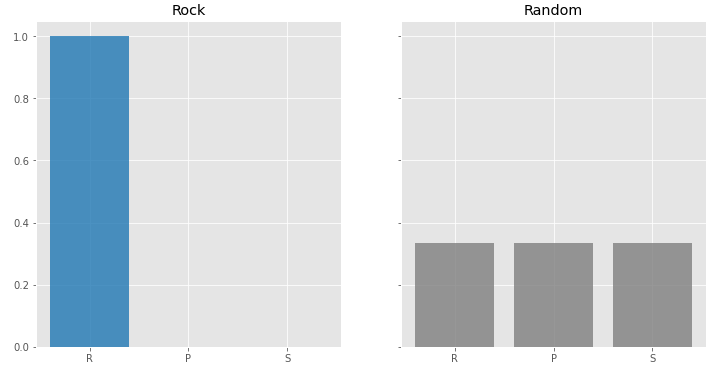

If one visualizes those distributions during one episode between `Rock` and `Random`, we'll see that they remain the same as those agents have a fixed strategy (have no capacity to coodapt). <br>
But for more sophisticated agents we can see the process of distiributions coodaptation. <br>
Such a visualisation can be insightfull or at least fun, so let's give it a try. <br>

## Content:
1. `Statistical` vs `Rock` (learnable vs static).
2. `Statistical` vs `Dirichlet` (learnable vs learnable).
3. `Statistical` vs `CNN` (learnable vs stronger learnable).
4. `CNN` vs `CNN` (fight with shadow).

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation

from kaggle_environments import evaluate, make, utils
from kaggle_environments.envs.rps.utils import get_score
from kaggle_environments.envs.rps.agents import *

plt.style.use('ggplot')
plt.rcParams["animation.html"] = "html5"

In [ ]:
def animate_progress(agents_logs, agents_names, save=False):
    
    agent1_log, agent2_log = agents_logs
    with open(agent1_log, 'rb') as f:
        agent1_log = pickle.load(f)
    with open(agent2_log, 'rb') as f:
        agent2_log = pickle.load(f)
    
    agent1_name, agent2_name = agents_names
    
    agent1_hist = agent1_log['dist']
    agent2_hist = agent2_log['dist']
    
    agent1_scores = agent1_log['score']
    agent2_scores = agent2_log['score']
    
    images = []
    steps = len(agent1_hist)

    fig, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
    for k in range(steps):

        ax[0].set_ylabel('$P$')
        ax[0].set_ylim([0, 1.1])
        img1 = ax[0].bar(['R', 'P', 'S'], agent1_hist[k], color='tab:blue', alpha=0.8)
        img2 = ax[1].bar(['R', 'P', 'S'], agent2_hist[k], color='tab:gray', alpha=0.8)
        img3 = ax[0].text(0.4,1.2, f'{agent1_name} score: {agent1_scores[k]:.0f}', fontsize=14)
        img4 = ax[1].text(0.4,1.2, f'{agent2_name} score: {agent2_scores[k]:.0f}', fontsize=14)
        img5 = ax[0].text(2.5,1.2, f'iteration: {k:.0f}', fontsize=12)
     
        images.append([*img1, *img2, img3, img4, img5])

    animation = ArtistAnimation(fig, images)
    plt.close()
    
    if save:
        animation.save('animation.gif', writer='imagemagick', fps=10)
        
    return animation

Let's start simple and look at the learning process of `Statistical` agent vs `Rock` agent:

In [ ]:
%%writefile statistical_agent.py

import pickle
import numpy as np
from kaggle_environments.envs.rps.utils import get_score


log = {'dist': [],
       'score': [0]}
log_file = 'statistical_agent.pkl'

with open(log_file, 'wb') as f:
  pickle.dump(log, f)

def update_log(probs, score, log_file):
    with open(log_file, 'rb') as f:
        log = pickle.load(f)
    log['dist'].append(list(probs))
    log['score'].append(log['score'][-1] + score)
    with open(log_file, 'wb') as f:
        pickle.dump(log, f)

action_histogram = {}
agent_last_action = []

def statistical(observation, configuration):
    
    global action_histogram, agent_last_action
    global log_file
    
    if observation.step == 0:
        action_histogram = {}
        return
    action = observation.lastOpponentAction
    if action not in action_histogram:
        action_histogram[action] = 0
    action_histogram[action] += 1
    mode_action = None
    mode_action_count = None
    
    if agent_last_action:
        score = get_score(agent_last_action[-1],
                         observation.lastOpponentAction)
    else:
        score = 0 
    
    probs = [0, 0, 0]
    for k, v in action_histogram.items():
        probs[k] = v
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v
            continue
        
    probs = np.exp(probs) / np.sum(np.exp(probs))    
    probs = np.roll(probs, 1)
    
    hand = (mode_action + 1) % configuration.signs
    agent_last_action.append(hand)
    
    update_log(probs, score, log_file)
    
    return hand

In [ ]:
%%writefile rock_agent.py

import pickle
from kaggle_environments.envs.rps.utils import get_score


agent_last_action = []
log_file = 'rock_agent.pkl'

log = {'dist': [],
       'score': [0]}

with open(log_file, 'wb') as f:
  pickle.dump(log, f)

def update_log(probs, score, log_file):
    with open(log_file, 'rb') as f:
        log = pickle.load(f)
    log['dist'].append(list(probs))
    log['score'].append(log['score'][-1] + score)
    with open(log_file, 'wb') as f:
        pickle.dump(log, f)

def rock(observation):
    
    global agent_last_action
    global log_file
    
    if agent_last_action:
        score = get_score(agent_last_action[-1],
                         observation.lastOpponentAction)
    else:
        score = 0 
    hand = 0
    probs = [1, 0, 0]
    agent_last_action.append(hand)
    
    update_log(probs, score, log_file)
    
    return hand

For those agents about 10 iterations are enough to converge, let's evaluate a short episode:

In [ ]:
env = make('rps', configuration={"episodeSteps": 50}, debug=True)
res = env.run(['statistical_agent.py', 'rock_agent.py'])

In [ ]:
agents_logs = ['statistical_agent.pkl', 'rock_agent.pkl']
agents_names = ['Statistical', 'Rock']

In [ ]:
animation = animate_progress(agents_logs, agents_names)
animation

So it works as expected, `Statistical` agent quickly adapts to static `Rock` agent and learns a winning distribution. <br>
Now let's explore something more interesting, let's put up `Statistical` agent with some adaptive agent, I use `Dirichlet` agent here:

In [ ]:
%%writefile dirichlet_agent.py

import pickle
import numpy as np
from kaggle_environments.envs.rps.utils import get_score


agent_last_action = []
log_file = 'dirichlet_agent.pkl'

log = {'dist': [],
       'score': [0]}

with open(log_file, 'wb') as f:
  pickle.dump(log, f)

def update_log(probs, score, log_file):
    with open(log_file, 'rb') as f:
        log = pickle.load(f)
    log['dist'].append(list(probs))
    log['score'].append(log['score'][-1] + score)
    with open(log_file, 'wb') as f:
        pickle.dump(log, f)

alphas = np.array([5, 5, 5])

def dirichlet_agent(observation, configuration):
    
    global alphas
    global agent_last_action
    global log_file
    
    if observation.step == 0:
        hand = np.random.randint(3)
        return hand
    
    opponent_last_action = observation.lastOpponentAction
    N = np.array([1 if i == opponent_last_action else 0 for i in range(3)])
    alphas += N
    probs = (alphas - 1) / np.sum(alphas - 1)
    opponent_next_acion = np.random.choice([0, 1, 2], p=probs)
    hand = (opponent_next_acion + 1) % 3
    
    if agent_last_action:
        score = get_score(agent_last_action[-1],
                         observation.lastOpponentAction)
    else:
        score = 0
    agent_last_action.append(hand)
    probs = np.roll(probs, 1)
    update_log(probs, score, log_file)
    
    return int(hand)

In [ ]:
env = make('rps', configuration={"episodeSteps": 1000}, debug=True)
res = env.run(['statistical_agent.py', 'dirichlet_agent.py'])

In [ ]:
agents_logs = ['statistical_agent.pkl', 'dirichlet_agent.pkl']
agents_names = ['Statistical', 'Dirichlet']

In [ ]:
animation = animate_progress(agents_logs, agents_names)
animation

So here we can see some patterns:
1. `Statistical` agent quickly converges to some local stationary state with probability about `1` for one of the actions. 
2. `Dirichlet` agent slowly adapts his distirbution to win aginst `Statistical` choosen state.
3. After some iterations `Statistical` has some quick transients and changes his preferable action, then the process repeats.

Now let's put `Statistical` agent with some relatively storng agent. For stronger agent I use `CNN` agent [described here](http://www.kaggle.com/glebkum/cnn-bot-for-rock-paper-scissors). 

In [ ]:
%%writefile cnn_agent.py

import os
import pickle
import numpy as np

import torch
from torch import nn, optim

from kaggle_environments import evaluate, make, utils
from kaggle_environments.envs.rps.utils import get_score


class RPS(nn.Module):
    """
    Class that predict logits of action probabilities given game history.
        Inputs: game history [bs, 2, 10].
        Outputs: logits of action probabilities [bs, 3].
    """
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 4, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(4, 8, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(8, 16, 2, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2)
        )
        self.head = nn.Sequential(
            nn.Linear(16, 6),
            nn.ReLU(),
            nn.Linear(6, 3)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x
    
    
def soft_cross_entropy(target, prediciton):
    log_probs = nn.functional.log_softmax(prediciton, dim=1)
    sce = -(target * log_probs).sum() / target.shape[0]
    return sce


def train_step(model, data, optimizer):
    model.train()
    torch.set_grad_enabled(True)

    X = data['X'].view(-1, 2, 10)
    y = data['y'].view(-1, 3)
    prd = model(X)
    loss = soft_cross_entropy(y, prd)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

bs = 6 # batch size  

opponent_actions = []
agent_actions = []
actions = []
batch_x = []
batch_y = []

log = {'dist': [],
       'score': [0]}
log_file = 'cnn_agent.pkl'

with open(log_file, 'wb') as f:
  pickle.dump(log, f)

def update_log(probs, score, log_file):
    with open(log_file, 'rb') as f:
        log = pickle.load(f)
    log['dist'].append(list(probs))
    log['score'].append(log['score'][-1] + score)
    with open(log_file, 'wb') as f:
        pickle.dump(log, f)

model = RPS()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def agent(observation, configuration):
    
    global actions, agent_actions, opponent_actions
    global model, optimizer
    global batch_x, batch_y
    global bs
    global log_file
    
    # first step
    if observation.step == 0:
        hand = np.random.randint(3)
        actions.append(hand)
        return hand
    
    # first warm up rounds
    if 0 < observation.step < 12:
        opponent_actions.append(observation.lastOpponentAction)
        agent_actions.append(actions[-1])
        hand = np.random.randint(3)
        actions.append(hand)
        
        probs = [1/3, 1/3, 1/3]
        score = get_score(agent_actions[-1], opponent_actions[-1])
        update_log(probs, score, log_file)
        
        return hand
    
    # start to train CNN
    elif observation.step >= 12:
        opponent_actions.append(observation.lastOpponentAction)
        agent_actions.append(actions[-1])
        
        score = get_score(agent_actions[-1], opponent_actions[-1])
        
        wining_action = (opponent_actions[-1] + 1) % 3 
        fair_action = opponent_actions[-1]
        lose_action = (opponent_actions[-1] - 1) % 3 

        # soft labels for target    
        y = [0, 0, 0]
        y[wining_action] = 0.7
        y[fair_action] = 0.2
        y[lose_action] = 0.1 
        
        # add data for history
        batch_x.append([opponent_actions[-2:-12:-1],
                        agent_actions[-2:-12:-1]])
        batch_y.append(y)
        
        # data for single CNN update 
        data = {'X': torch.Tensor([opponent_actions[-2:-12:-1],
                                   agent_actions[-2:-12:-1]]),
                'y': torch.Tensor(y)} 
        
        # evaluate single training step
        train_step(model, data, optimizer)
        
        # evaluate mini-batch training steps
        if observation.step % 10 == 0:
            k = 1 if observation.step < 100 else 3
            for _ in range(k):
                idxs = np.random.choice(list(range(len(batch_y))), bs)
                data = {'X': torch.Tensor(np.array(batch_x)[idxs]),
                        'y': torch.Tensor(np.array(batch_y)[idxs])}
                train_step(model, data, optimizer)
        
        # data for current action prediction
        X_prd = torch.Tensor([opponent_actions[-1:-11:-1],
                              agent_actions[-1:-11:-1]]).view(1, 2, -1)
        
        # predict logits
        probs = model(X_prd).view(3)
        # calculate probabilities
        probs = nn.functional.softmax(probs, dim=0).detach().cpu().numpy()
        
        update_log(probs, score, log_file)
        
        # choose action
        hand = np.random.choice([0, 1, 2], p=probs)
        actions.append(hand)
        
        return int(hand)

Here things become more interesting, so let's evaluate the full episode:

In [ ]:
env = make('rps', configuration={"episodeSteps": 1000}, debug=True)
res = env.run(['statistical_agent.py', 'cnn_agent.py'])

In [ ]:
agents_logs = ['statistical_agent.pkl', 'cnn_agent.pkl']
agents_names = ['Statistical', 'CNN']

In [ ]:
animation = animate_progress(agents_logs, agents_names)
animation

Here `Statistical` agent behaviour is similar, but `CNN` agent finds a more flexible way to adapt and beats it more frequently than `Dirichlet` agent.

Finally lets see fight with own shadow `CNN` vs `CNN`:

In [ ]:
%%writefile cnn_agent_1.py

import os
import pickle
import numpy as np

import torch
from torch import nn, optim

from kaggle_environments import evaluate, make, utils
from kaggle_environments.envs.rps.utils import get_score


class RPS(nn.Module):
    """
    Class that predict logits of action probabilities given game history.
        Inputs: game history [bs, 2, 10].
        Outputs: logits of action probabilities [bs, 3].
    """
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 4, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(4, 8, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(8, 16, 2, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2)
        )
        self.head = nn.Sequential(
            nn.Linear(16, 6),
            nn.ReLU(),
            nn.Linear(6, 3)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x
    
    
def soft_cross_entropy(target, prediciton):
    log_probs = nn.functional.log_softmax(prediciton, dim=1)
    sce = -(target * log_probs).sum() / target.shape[0]
    return sce


def train_step(model, data, optimizer):
    model.train()
    torch.set_grad_enabled(True)

    X = data['X'].view(-1, 2, 10)
    y = data['y'].view(-1, 3)
    prd = model(X)
    loss = soft_cross_entropy(y, prd)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

bs = 6 # batch size  

opponent_actions = []
agent_actions = []
actions = []
batch_x = []
batch_y = []

log = {'dist': [],
       'score': [0]}
log_file = 'cnn_agent_1.pkl'

with open(log_file, 'wb') as f:
  pickle.dump(log, f)

def update_log(probs, score, log_file):
    with open(log_file, 'rb') as f:
        log = pickle.load(f)
    log['dist'].append(list(probs))
    log['score'].append(log['score'][-1] + score)
    with open(log_file, 'wb') as f:
        pickle.dump(log, f)

model = RPS()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def agent(observation, configuration):
    
    global actions, agent_actions, opponent_actions
    global model, optimizer
    global batch_x, batch_y
    global bs
    global log_file
    
    # first step
    if observation.step == 0:
        hand = np.random.randint(3)
        actions.append(hand)
        return hand
    
    # first warm up rounds
    if 0 < observation.step < 12:
        opponent_actions.append(observation.lastOpponentAction)
        agent_actions.append(actions[-1])
        hand = np.random.randint(3)
        actions.append(hand)
        
        probs = [1/3, 1/3, 1/3]
        score = get_score(agent_actions[-1], opponent_actions[-1])
        update_log(probs, score, log_file)
        
        return hand
    
    # start to train CNN
    elif observation.step >= 12:
        opponent_actions.append(observation.lastOpponentAction)
        agent_actions.append(actions[-1])
        
        score = get_score(agent_actions[-1], opponent_actions[-1])
        
        wining_action = (opponent_actions[-1] + 1) % 3 
        fair_action = opponent_actions[-1]
        lose_action = (opponent_actions[-1] - 1) % 3 

        # soft labels for target    
        y = [0, 0, 0]
        y[wining_action] = 0.7
        y[fair_action] = 0.2
        y[lose_action] = 0.1 
        
        # add data for history
        batch_x.append([opponent_actions[-2:-12:-1],
                        agent_actions[-2:-12:-1]])
        batch_y.append(y)
        
        # data for single CNN update 
        data = {'X': torch.Tensor([opponent_actions[-2:-12:-1],
                                   agent_actions[-2:-12:-1]]),
                'y': torch.Tensor(y)} 
        
        # evaluate single training step
        train_step(model, data, optimizer)
        
        # evaluate mini-batch training steps
        if observation.step % 10 == 0:
            k = 1 if observation.step < 100 else 3
            for _ in range(k):
                idxs = np.random.choice(list(range(len(batch_y))), bs)
                data = {'X': torch.Tensor(np.array(batch_x)[idxs]),
                        'y': torch.Tensor(np.array(batch_y)[idxs])}
                train_step(model, data, optimizer)
        
        # data for current action prediction
        X_prd = torch.Tensor([opponent_actions[-1:-11:-1],
                              agent_actions[-1:-11:-1]]).view(1, 2, -1)
        
        # predict logits
        probs = model(X_prd).view(3)
        # calculate probabilities
        probs = nn.functional.softmax(probs, dim=0).detach().cpu().numpy()
        
        update_log(probs, score, log_file)
        
        # choose action
        hand = np.random.choice([0, 1, 2], p=probs)
        actions.append(hand)
        
        return int(hand)

In [ ]:
env = make('rps', configuration={"episodeSteps": 1000}, debug=True)
res = env.run(['cnn_agent.py', 'cnn_agent_1.py'])

In [ ]:
agents_logs = ['cnn_agent.pkl', 'cnn_agent_1.pkl']
agents_names = ['CNN', 'CNN_1']

In [ ]:
animation = animate_progress(agents_logs, agents_names)
animation

So, the agents with the same adaptation speed behave almost randomly and never stick to some unimodal strategy. <br>
It is interesting to notice that if one does not sample form bot distribution but use `argmax` instead, the agent becomes way more deterministic and can be predicted easily (note that position of maximum probability changes not so frequently). <br>
<br>
So it is seems that a strong agent should be close to the random (should have almost flat distribution) to avoid being predicted and rapidly adapt to opponent's distribution by adding a bit more probability to the current winning action. <br>
Now it is just there is one small thing left to do - is to write such a bot :)